## Data Cleaning and Preprocessing

In [26]:
#library imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
#read data
data_folder = ('../Data/')
train = pd.read_csv(data_folder+'sales_train.csv')
test = pd.read_csv(data_folder+'test.csv')
submission = pd.read_csv(data_folder+'sample_submission.csv')
items = pd.read_csv(data_folder+'items.csv')
item_cat = pd.read_csv(data_folder+'item_categories.csv')
shops = pd.read_csv(data_folder+'shops.csv')

In [14]:
print("Training shape before join : ", train.shape)
print("Test shape before join : ", test.shape)

Training shape before join :  (2935849, 6)
Test shape before join :  (214200, 3)


In [15]:
# Join train and test with items to get item_category_id
train = pd.merge(train, items, how='inner', on='item_id')
test = pd.merge(test, items, how='inner', on='item_id')

print("Training shape after join: ", train.shape)
print("Testing shape after join: ", test.shape)
print("Null count of item_category_id in train: ", train['item_category_id'].isnull().sum())
print("Null count of item_category_id in test: ", test['item_category_id'].isnull().sum())

Training shape after join:  (2935849, 8)
Testing shape after join:  (214200, 5)
Null count of item_category_id in train:  0
Null count of item_category_id in test:  0


In [16]:
# Decasting columns to reduce memory use
# Cite: https://www.kaggle.com/kyakovlev/1st-place-solution-part-1-hands-on-data
# Helps reduce memory footprint of training data from 169 to 89 mb.

def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

train = downcast_dtypes(train)
test = downcast_dtypes(test)
print(train.info())
print(test.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 8 columns):
 #   Column            Dtype  
---  ------            -----  
 0   date              object 
 1   date_block_num    int16  
 2   shop_id           int16  
 3   item_id           int16  
 4   item_price        float32
 5   item_cnt_day      float32
 6   item_name         object 
 7   item_category_id  int16  
dtypes: float32(2), int16(4), object(2)
memory usage: 112.0+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 214200 entries, 0 to 214199
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   ID                214200 non-null  int16 
 1   shop_id           214200 non-null  int16 
 2   item_id           214200 non-null  int16 
 3   item_name         214200 non-null  object
 4   item_category_id  214200 non-null  int16 
dtypes: int16(4), object(1)
memory usage: 4.9+ MB
None


In [17]:
train.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'item_name', 'item_category_id'],
      dtype='object')

### Data Cleaning and preprocessing

In [21]:
# remove negatively priced items 
train = train.query('item_price > 0')
# remove text features as they are in russian
# drop item_name column
train = train.drop(['item_name'],axis=1)
test = test.drop(['item_name'],axis=1)

KeyError: "['item_name'] not found in axis"

In [22]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,02.01.2013,0,59,22154,999.0,1.0,37
1,23.01.2013,0,24,22154,999.0,1.0,37
2,20.01.2013,0,27,22154,999.0,1.0,37
3,02.01.2013,0,25,22154,999.0,1.0,37
4,03.01.2013,0,25,22154,999.0,1.0,37


## Exploratory Data Analysis

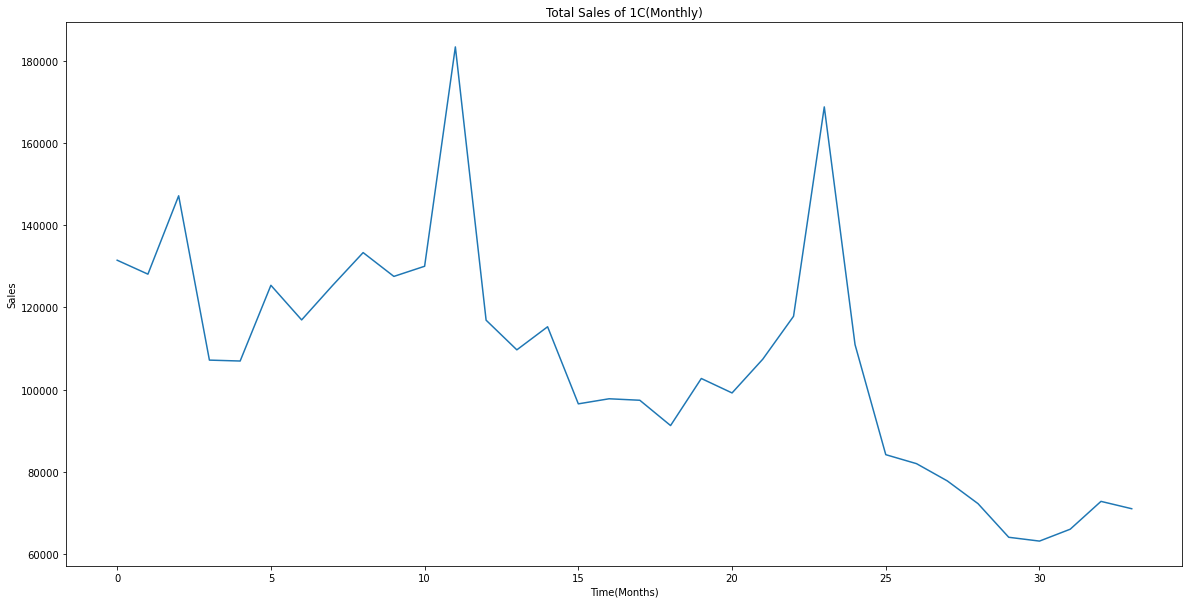

In [30]:
# total sales over whole data
f, axes = plt.subplots(figsize=(20, 10))
train.groupby(["date_block_num"])["item_cnt_day"].sum()
plt.title('Total Sales of 1C(Monthly)')
plt.xlabel('Time(Months)')
plt.ylabel('Sales')
plt.plot(train.groupby(["date_block_num"])["item_cnt_day"].sum())
plt.show()

/opt/anaconda3/envs/vartikarootenv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


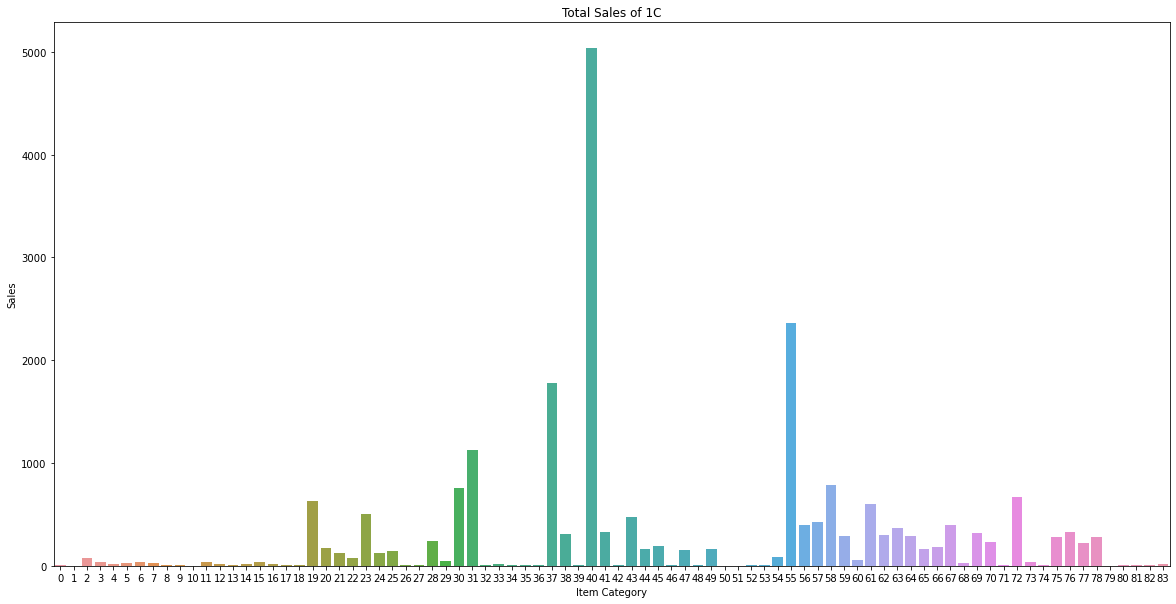

In [32]:
# total sales on item cat id
f, axes = plt.subplots(figsize=(20, 10))
x = items.groupby(['item_category_id']).count()
x=x.reset_index()
sns.barplot(x['item_category_id'], x['item_id'],ax=axes)
plt.title('Total Sales of 1C')
plt.xlabel('Item Category')
plt.ylabel('Sales')
plt.show()

/opt/anaconda3/envs/vartikarootenv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


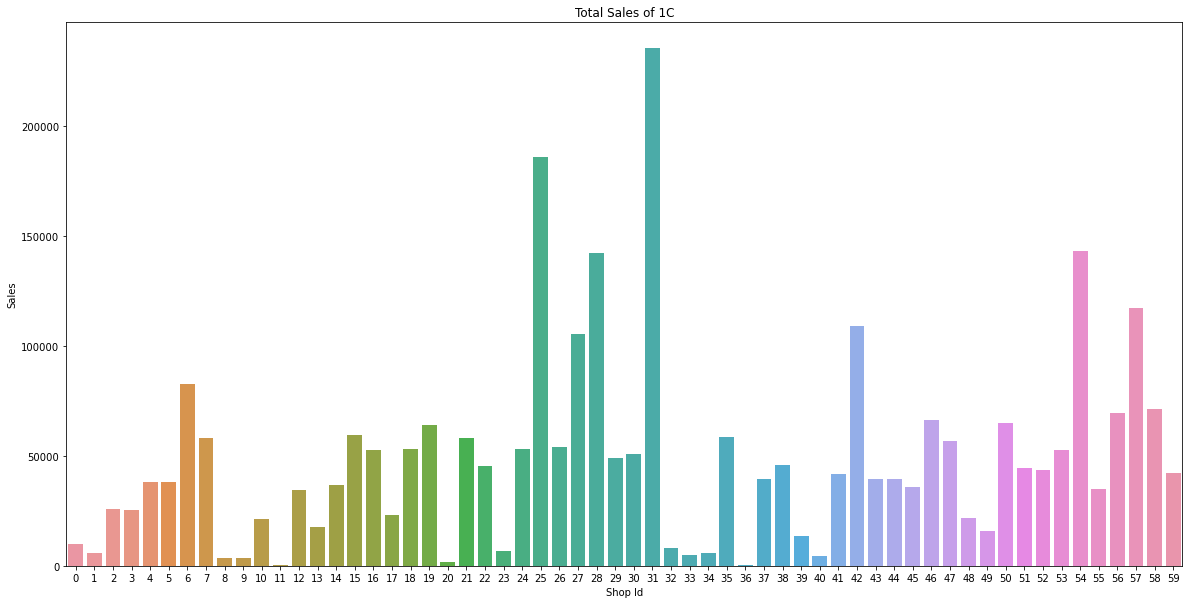

In [34]:
# total sales on shop id
f, axes = plt.subplots(figsize=(20, 10))
x = train.groupby(['shop_id']).count()
x=x.reset_index()
sns.barplot(x['shop_id'], x['item_id'],ax=axes)
plt.title('Total Sales of 1C')
plt.xlabel('Shop Id')
plt.ylabel('Sales')
plt.show()

In [44]:
# Group by date_block_num
monthly_train = train.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'], as_index=False)
monthly_train = monthly_train.agg({'item_price':['mean'], 'item_cnt_day':['sum', 'mean','count']})
# Rename columns
monthly_train.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'num_transactions']
monthly_train['item_cnt_month'] = monthly_train.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)
monthly_train = monthly_train.fillna(0)
monthly_train.head()

,date_block_num,shop_id,item_category_id,item_id,mean_item_price,item_cnt,mean_item_cnt,num_transactions,item_cnt_month
0,0,0,2,5572,1322.0,10.0,1.666667,6,11.0
1,0,0,2,5573,560.0,1.0,1.000000,1,1.0
2,0,0,2,5575,806.0,4.0,1.333333,3,0.0
3,0,0,2,5576,2231.0,5.0,1.000000,5,2.0
4,0,0,2,5609,2381.0,1.0,1.000000,1,1.0


In [45]:
monthly_train.to_csv('../Data/monthly_train.csv')